In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
def generate_features(
    count: int = 10000,
) -> pd.DataFrame:
    x = np.random.uniform(-1, 1, count)
    y = np.random.uniform(-1, 1, count)
    cls = np.where((x ** 2 + y ** 2) <= .25, 1, 0)
    return pd.DataFrame({'x': x, 'y': y, 'cls': cls})

In [3]:
def get_predictions(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> np.ndarray:
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([tp, fp, tn, fn])


def accuracy(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> float:
    tp, fp, tn, fn = get_predictions(y_true, y_pred)
    return (tp + tn) / (tp + fp + tn + fn)


def precision(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> float:
    tp, fp, tn, fn = get_predictions(y_true, y_pred)
    return tp / (tp + fp)


def recall(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> float:
    tp, fp, tn, fn = get_predictions(y_true, y_pred)
    return tp / (tp + fn)


def f1_score(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> float:
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r)

In [4]:
def get_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> pd.DataFrame:
    return pd.DataFrame({
        'accuracy': [accuracy(y_true, y_pred)],
        'precision': [precision(y_true, y_pred)],
        'recall': [recall(y_true, y_pred)],
        'f1_score': [f1_score(y_true, y_pred)],
    })

In [5]:
features = generate_features()
features.head()

,x,y,cls
0,0.206990,0.287932,1
1,0.667053,0.506079,0
2,0.707954,-0.498632,0
3,-0.776361,-0.799973,0
4,0.350140,0.012067,1


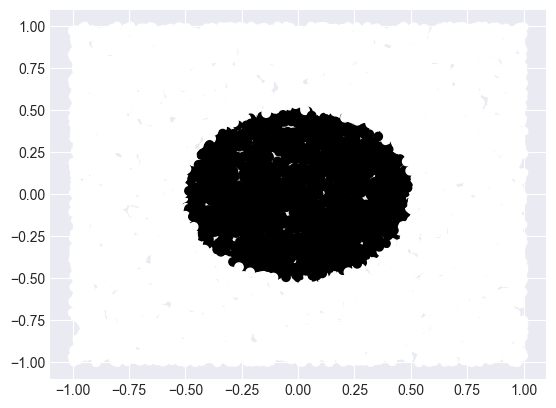

In [6]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

plt.scatter(features.x, features.y, c=features.cls)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features[['x', 'y']],
    features['cls'],
    test_size=0.2,
    random_state=42,
)

Попробуем поиграть с разными ядрами модели для NuSVC

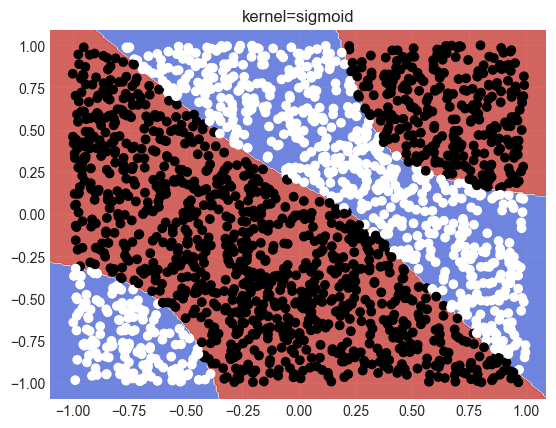

   accuracy  precision    recall  f1_score
0     0.436   0.214626  0.658537  0.323741


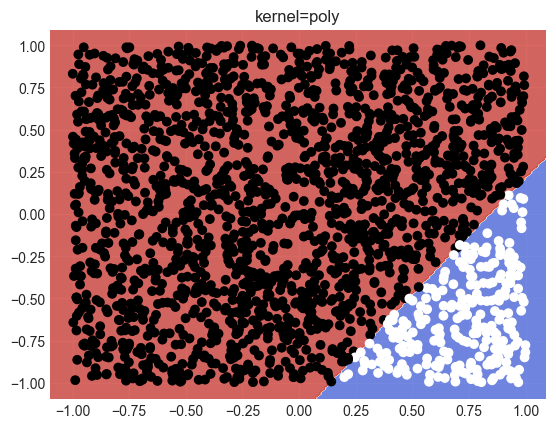

   accuracy  precision  recall  f1_score
0    0.3285   0.233885     1.0  0.379103


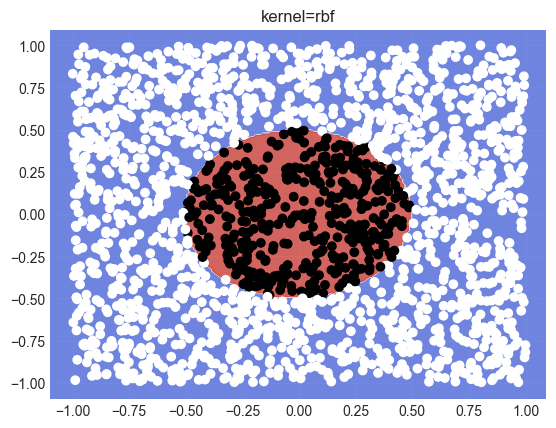

   accuracy  precision    recall  f1_score
0    0.9945   0.995037  0.978049   0.98647


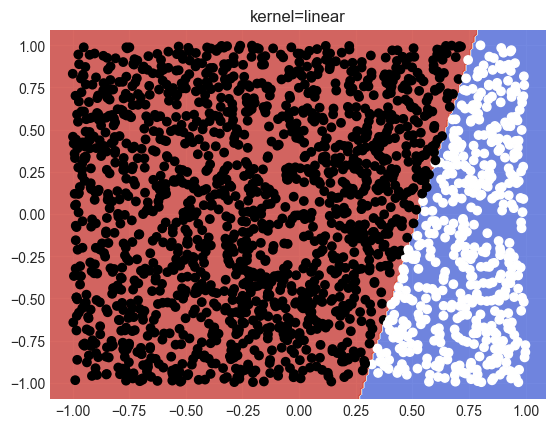

   accuracy  precision  recall  f1_score
0     0.436    0.26658     1.0  0.420945


In [8]:
from sklearn.svm import NuSVC


def plot_hypersurface(
    model: NuSVC,
    x: pd.DataFrame,
    y: pd.Series,
) -> None:
    x_min, x_max = x.x.min() - .1, x.x.max() + .1
    y_min, y_max = x.y.min() - .1, x.y.max() + .1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, .01),
        np.arange(y_min, y_max, .01),
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, cmap=plt.cm.coolwarm)
    plt.scatter(x.x, x.y, c=y)


for kernel in ['sigmoid', 'poly', 'rbf', 'linear']:
    model = NuSVC(kernel=kernel, nu=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.scatter(X_test.x, X_test.y, c=y_pred, alpha=.5)
    plt.title(f'kernel={kernel}')
    plot_hypersurface(model, X_test, y_pred)
    plt.show()
    print(get_metrics(y_test, y_pred))

Лучше всего себя показал гауссовский кернел, поэтому будем использовать его для дальнейшего обучения. Гауссовский кернел показал себя лучше всего, так как он позволяет разделять данные с помощью гиперплоскости, которая не является линейной.

Поиграем с объемом обучающей выборки

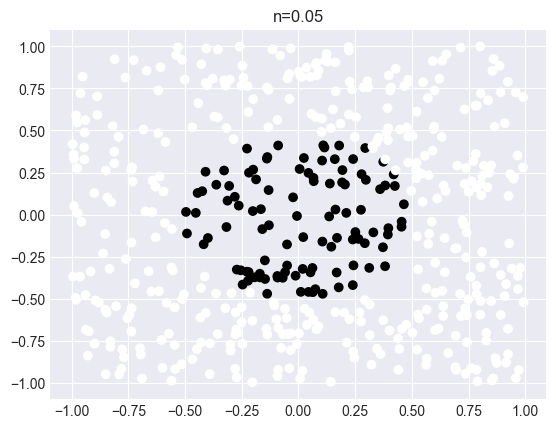

   accuracy  precision  recall  f1_score
0     0.998   0.990476     1.0  0.995215


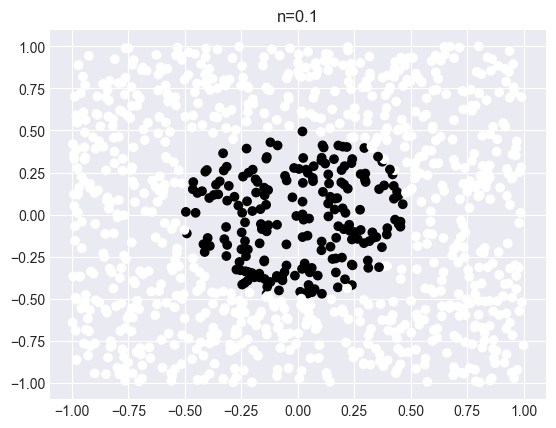

   accuracy  precision    recall  f1_score
0     0.992   0.990099  0.970874  0.980392


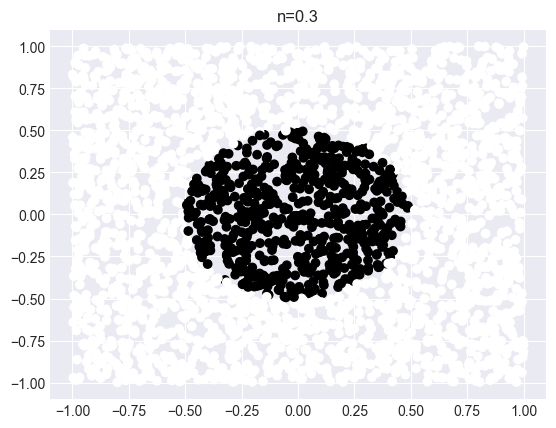

   accuracy  precision    recall  f1_score
0  0.995333   0.996639  0.980165  0.988333


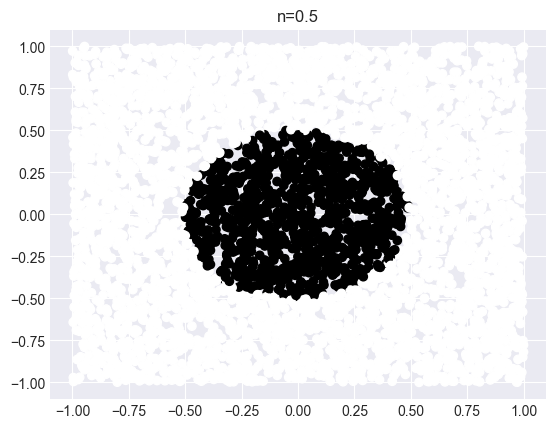

   accuracy  precision    recall  f1_score
0    0.9964   0.994059  0.988189  0.991115


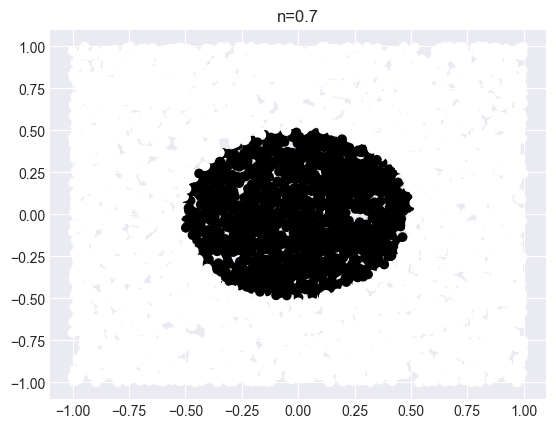

   accuracy  precision    recall  f1_score
0  0.995429   0.993617  0.983848  0.988709


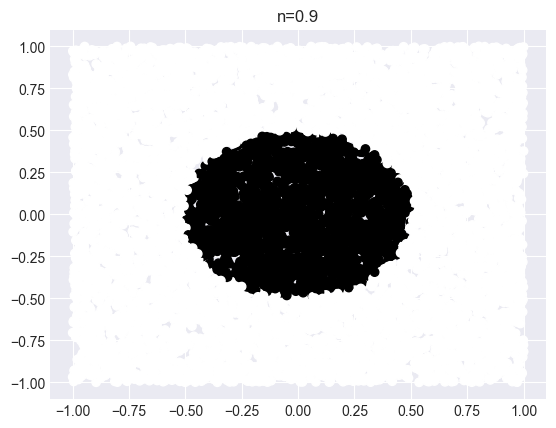

   accuracy  precision    recall  f1_score
0  0.995333   0.995575  0.981461  0.988468


In [9]:
for n in [0.05, 0.1, 0.3, 0.5, 0.7, 0.9]:
    X_train, X_test, y_train, y_test = train_test_split(
        features[['x', 'y']],
        features['cls'],
        test_size=n,
        random_state=42,
    )
    model = NuSVC(kernel='rbf', nu=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.scatter(X_test.x, X_test.y, c=y_pred)
    plt.title(f'n={n}')
    plt.show()
    print(get_metrics(y_test, y_pred))

При увеличении объема обучающей выборки, точность модели увеличивается. Это связано с тем, что при увеличении объема обучающей выборки, модель становится более обобщающей, и поэтому она лучше работает на тестовой выборке.

Попробуем поиграть с параметром nu -- нижней границей доли опорных векторов

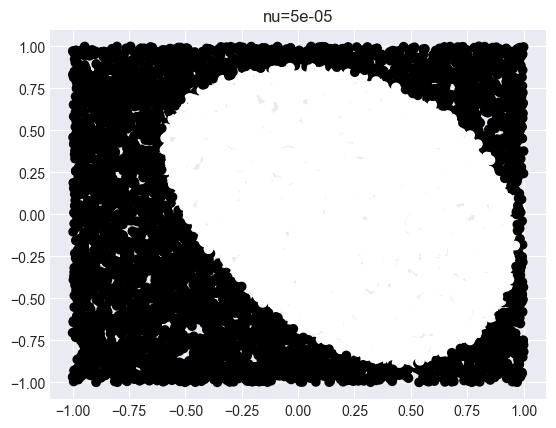

   accuracy  precision   recall  f1_score
0  0.317222   0.008662  0.02072  0.012217


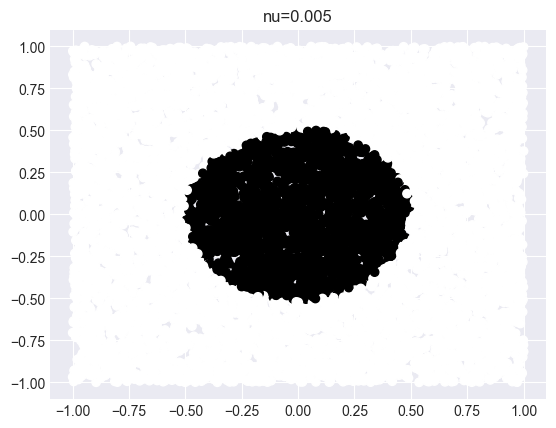

   accuracy  precision    recall  f1_score
0  0.995778   0.990175  0.989095  0.989634


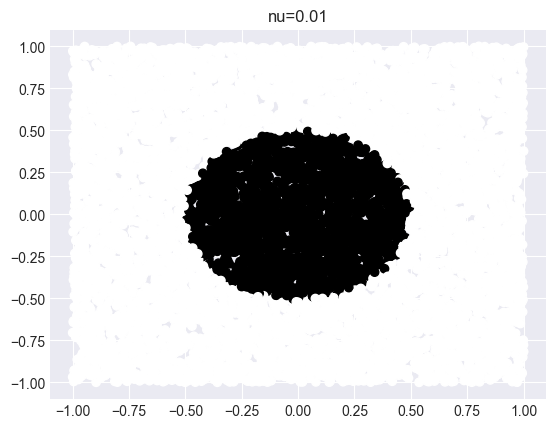

   accuracy  precision    recall  f1_score
0  0.997444   0.995079  0.992366  0.993721


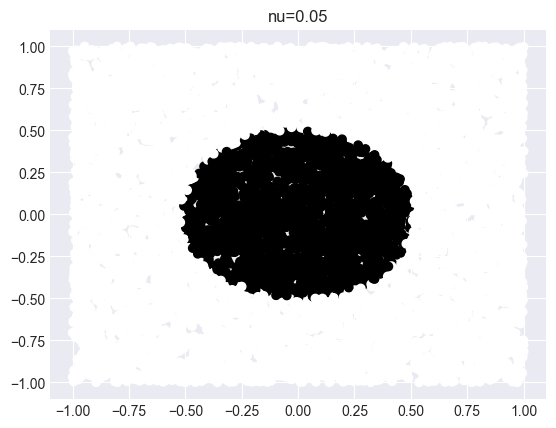

   accuracy  precision    recall  f1_score
0  0.995222   0.979646  0.997274  0.988382


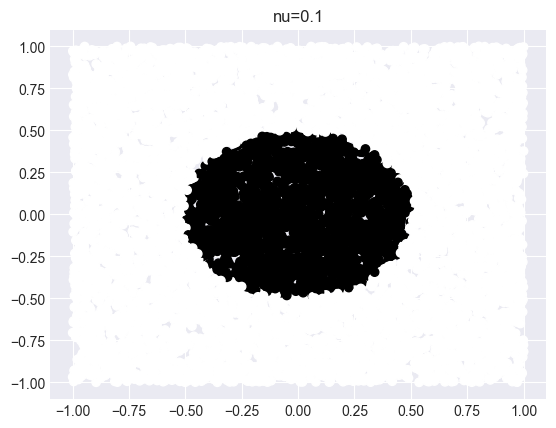

   accuracy  precision    recall  f1_score
0  0.995333   0.995575  0.981461  0.988468


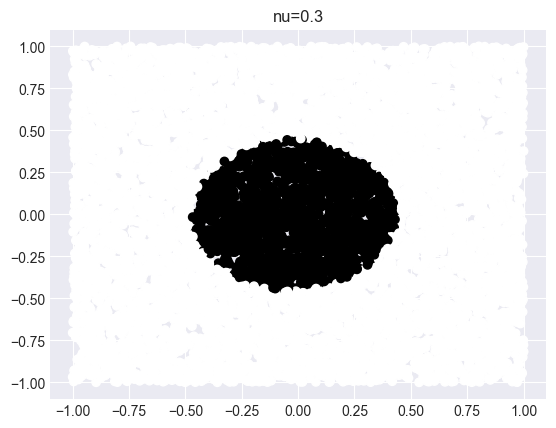

   accuracy  precision    recall  f1_score
0     0.961        1.0  0.808615  0.894181
nu=0.45 error: specified nu is infeasible
nu=0.5 error: specified nu is infeasible
nu=0.7 error: specified nu is infeasible
nu=0.9 error: specified nu is infeasible


In [10]:
for nu in [0.00005, 0.005, 0.01, 0.05, 0.1, 0.3, 0.45, 0.5, 0.7, 0.9]:
    model = NuSVC(kernel='rbf', nu=nu)
    try:
        model.fit(X_train, y_train)
    except ValueError as e:
        print(f'nu={nu} error: {e}')
        continue

    y_pred = model.predict(X_test)
    plt.scatter(X_test.x, X_test.y, c=y_pred)
    plt.title(f'nu={nu}')
    plt.show()
    print(get_metrics(y_test, y_pred))

Нижняя граница доли опорных векторов не должна быть меньше, чем доля классов в обучающей выборке. Поэтому при очень маленьких и очень больших значениях параметра nu, модель недообучается и не может обучиться соответственно.